In [1]:
import wandb
import os

# auto reload
%load_ext autoreload
%autoreload 2


Saved in 

`onpolicy/results/GraphMPE/navigation_graph/rmappo/informarl/wandb`

to run evaluation script, use:

```
xvfb-run -a -s "-screen 0 1400x900x24" python -u onpolicy/scripts/eval_mpe.py --model_dir onpolicy/results/GraphMPE/navigation_graph/rmappo/informarl/wandb/run-20250312_024502-j08n9m0q/files

python onpolicy/scripts/eval_mpe.py --model_dir onpolicy/trained_models/informarl_3agents_target/files
```



In [2]:
import pyglet
pyglet.window.Window()

NoSuchDisplayException: Cannot connect to "None"

t

- 3 agents at 
> `onpolicy/results/GraphMPE/navigation_graph/rmappo/informarl/wandb/run-20250312_024502-j08n9m0q/files`

In [3]:
import torch
print(torch.__version__)

2.5.1


## Test noise levels

In [8]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
from distutils.util import strtobool
import os, sys
import copy
sys.path.append(os.path.abspath(os.getcwd()))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))



In [3]:
from multiagent.MPE_env import GraphMPEEnv, NoisyGraphMPEEnv
from multiagent.custom_scenarios import load

In [91]:

from gym import spaces
from multiagent.multi_discrete import MultiDiscrete

class Args:
    def __init__(self):
        self.scenario_name = "navigation_graph"
        self.num_agents = 3
        self.world_size = 2
        self.num_scripted_agents = 0
        self.num_obstacles = 3
        self.collaborative = True
        self.max_speed = 2
        self.collision_rew = 5
        self.goal_rew = 5
        self.min_dist_thresh = 0.1
        self.use_dones = False
        self.episode_length = 25
        self.max_edge_dist = 1
        self.graph_feat_type = "global"
        self.seed = 42

def create_env(args, obs_noise=0.0, dyn_noise=0.0):
    args.obs_noise_level = obs_noise
    args.dyn_noise_level = dyn_noise
    if obs_noise > 0 or dyn_noise > 0:
        return NoisyGraphMPEEnv(args)
    else:
        return GraphMPEEnv(args)


def test_observation_noise(obs_noise_levels, steps=10):
    """Test how observation noise affects agent observations"""
    results = {}
    
    for noise_level in obs_noise_levels:
        position_diffs = []
        reward_diffs = []
        
        for _ in range(5):  # 5 episodes
            # Create clean and noisy envs
            clean_env = create_env(args)
            noisy_env = create_env(args, obs_noise=noise_level)
            
            # Reset both to same initial state
            clean_env.reset()
            noisy_env.reset()
            noisy_env.world = copy.deepcopy(clean_env.world)
            
            for _ in range(steps):
                # Take same random actions in both envs
                actions = generate_random_actions(args.num_agents, clean_env.action_space[0]) 
                           
                # Step clean env
                _, _, _, _, clean_rewards, _, _ = clean_env.step(actions)
                
                # Step noisy env with same actions
                _, _, _, _, noisy_rewards, _, _ = noisy_env.step(actions)
                
                # Measure position differences
                pos_diffs = []
                for i in range(args.num_agents):
                    clean_pos = clean_env.world.agents[i].state.p_pos
                    noisy_pos = noisy_env.world.agents[i].state.p_pos
                    pos_diff = np.linalg.norm(clean_pos - noisy_pos)
                    pos_diffs.append(pos_diff)
                
                # Measure reward differences
                rew_diffs = []
                for i in range(args.num_agents):
                    rew_diff = abs(sum(clean_rewards[i]) - sum(noisy_rewards[i]))
                    rew_diffs.append(rew_diff)
                
                position_diffs.append(np.mean(pos_diffs))
                reward_diffs.append(np.mean(rew_diffs))
        
        results[noise_level] = {
            'position_diff': np.mean(position_diffs),
            'reward_diff': np.mean(reward_diffs)
        }
    return results

def test_dynamics_noise(dyn_noise_levels, steps=10):
    """Test how dynamics noise affects agent positions over time"""
    results = {}
    
    for noise_level in dyn_noise_levels:
        position_diffs = []
        reward_diffs = []
        
        for _ in range(5):  # 5 episodes
            # Create clean and noisy envs
            clean_env = create_env(args)
            noisy_env = create_env(args, dyn_noise=noise_level)
            
            # Reset both to same initial state
            clean_env.reset()
            noisy_env.reset()
            noisy_env.world = copy.deepcopy(clean_env.world)
            
            for _ in range(steps):
                # Take same random actions in both envs
                actions = generate_random_actions(args.num_agents, clean_env.action_space[0]) 
                # Step clean env
                _, _, _, _, clean_rewards, _, _ = clean_env.step(actions)
                
                # Step noisy env with same actions
                _, _, _, _, noisy_rewards, _, _ = noisy_env.step(actions)
                
                # Measure position differences
                pos_diffs = []
                for i in range(args.num_agents):
                    clean_pos = clean_env.world.agents[i].state.p_pos
                    noisy_pos = noisy_env.world.agents[i].state.p_pos
                    pos_diff = np.linalg.norm(clean_pos - noisy_pos)
                    pos_diffs.append(pos_diff)
                
                # Measure reward differences
                rew_diffs = []
                for i in range(args.num_agents):
                    rew_diff = abs(sum(clean_rewards[i]) - sum(noisy_rewards[i]))
                    rew_diffs.append(rew_diff)
                
                position_diffs.append(np.mean(pos_diffs))
                reward_diffs.append(np.mean(rew_diffs))
        
        results[noise_level] = {
            'position_diff': np.mean(position_diffs),
            'reward_diff': np.mean(reward_diffs)
        }
        
    return results

def plot_results(obs_results, dyn_results):
    """Plot the results of noise testing"""
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot observation noise results
    obs_levels = sorted(obs_results.keys())
    pos_diffs = [obs_results[l]['position_diff'] for l in obs_levels]
    rew_diffs = [obs_results[l]['reward_diff'] for l in obs_levels]
    
    axs[0, 0].plot(obs_levels, pos_diffs, 'o-')
    axs[0, 0].set_title('Observation Noise Impact on Position')
    axs[0, 0].set_xlabel('Noise Level (std)')
    axs[0, 0].set_ylabel('Average Position Difference')
    
    axs[0, 1].plot(obs_levels, rew_diffs, 'o-')
    axs[0, 1].set_title('Observation Noise Impact on Reward')
    axs[0, 1].set_xlabel('Noise Level (std)')
    axs[0, 1].set_ylabel('Average Reward Difference')
    
    # Plot dynamics noise results
    dyn_levels = sorted(dyn_results.keys())
    pos_diffs = [dyn_results[l]['position_diff'] for l in dyn_levels]
    rew_diffs = [dyn_results[l]['reward_diff'] for l in dyn_levels]
    
    axs[1, 0].plot(dyn_levels, pos_diffs, 'o-')
    axs[1, 0].set_title('Dynamics Noise Impact on Position')
    axs[1, 0].set_xlabel('Noise Level (std)')
    axs[1, 0].set_ylabel('Average Position Difference')
    
    axs[1, 1].plot(dyn_levels, rew_diffs, 'o-')
    axs[1, 1].set_title('Dynamics Noise Impact on Reward')
    axs[1, 1].set_xlabel('Noise Level (std)')
    axs[1, 1].set_ylabel('Average Reward Difference')
    
    plt.tight_layout()
    plt.savefig('noise_analysis.png')
    plt.show()
    
    # Print recommendations
    pos_threshold = 0.2  # threshold for reasonable position drift
    
    # Find reasonable observation noise
    reasonable_obs = max([l for l, r in obs_results.items() 
                        if r['position_diff'] < pos_threshold], default=0.01)
    
    # Find reasonable dynamics noise
    reasonable_dyn = max([l for l, r in dyn_results.items() 
                        if r['position_diff'] < pos_threshold], default=0.01)
    
    print("\nRECOMMENDED NOISE LEVELS:")
    print(f"Observation noise: Around {reasonable_obs:.3f}")
    print(f"Dynamics noise: Around {reasonable_dyn:.3f}")
    print("\nGuidelines:")
    print("- Low noise (~0.01): Minimal impact, good for initial training")
    print("- Medium noise (~0.05-0.1): Noticeable impact, good for robustness training")
    print("- High noise (>0.2): Significant disruption, challenging environment")



In [86]:
args = Args()
args.obs_noise_level = 0.0
args.dyn_noise_level = 0.0
scenario = load(args.scenario_name + ".py").Scenario()

env = NoisyGraphMPEEnv(args)
# print observation space of world
env.observation_space
for i in range(len(env.agents)):
    print(env.world.agents[i].state.p_pos)


[-0.58229321 -0.26330681]
[-0.13929153 -0.09354559]
[-0.94945933 -0.41908991]


In [87]:
# print action space of world
env.action_space, env.discrete_action_input, env.discrete_action_space

([Discrete(5), Discrete(5), Discrete(5)], False, True)

In [88]:
def generate_random_actions(num_agents, action_space):
    actions = []
    for _ in range(num_agents):
        if isinstance(action_space, spaces.Discrete):
            #one hot action 
            action = np.zeros(action_space.n)
            action[np.random.randint(0, action_space.n)] = 1
        elif isinstance(action_space, MultiDiscrete):
            action = [np.random.randint(low, high + 1) for low, high in zip(action_space.low, action_space.high)]
        else:
            #type of action space
            print(type(action_space))
            raise NotImplementedError("Action space type not supported for random generation.")
        actions.append(action)
    return actions


Testing observation noise levels...
Testing dynamics noise levels...


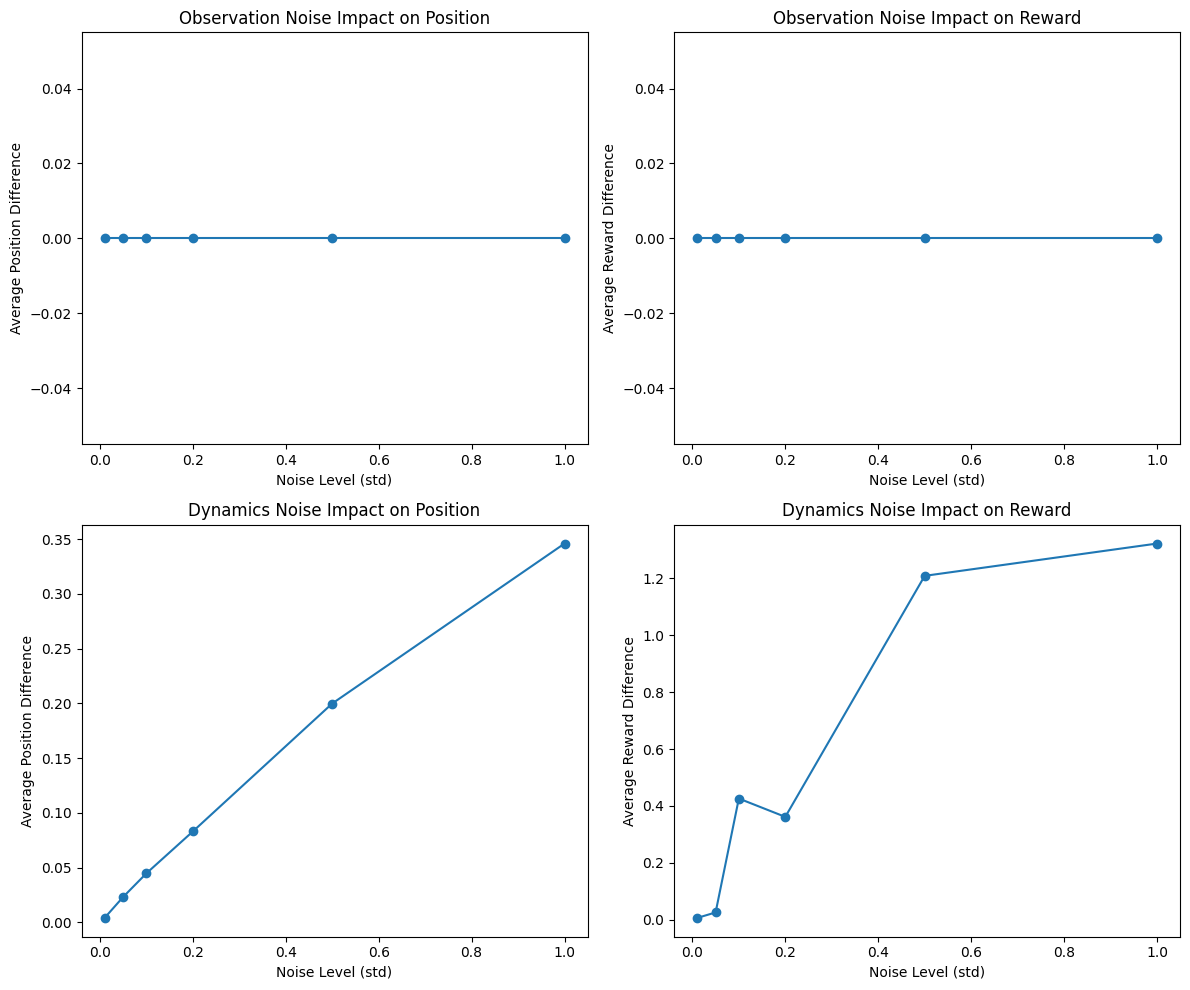

KeyError: 'obs_diff_mean'

In [89]:
# Set up environment
args = Args()
scenario = load(args.scenario_name + ".py").Scenario()

# Test various noise levels
obs_noise_levels = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
dyn_noise_levels = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]

print("Testing observation noise levels...")
obs_results = test_observation_noise(obs_noise_levels)

print("Testing dynamics noise levels...")
dyn_results = test_dynamics_noise(dyn_noise_levels)

# Display results
plot_results(obs_results, dyn_results)